<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/02_pyTorchNeuralNetworkClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 02. Neural Network Classification with PyTorch 

 Classification is a problem of prediction whether something is one thing or another (can be multiple options)

## 1. Make data and get it ready 

In [1]:
import sklearn 
from sklearn.datasets import make_circles

# Make 1000 samples 
nSamples = 1000 

# Create circles
X, y = make_circles(nSamples,
                    noise = 0.03,
                    random_state = 42)

In [2]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [3]:
# make DataFrame of circle data
import pandas as pd 
circles = pd.DataFrame({"X1": X[:,0], "X2" : X[:,1], "label":y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


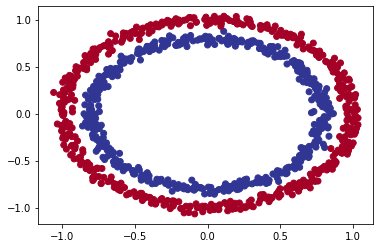

In [4]:
# visualize data 
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

## 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and lavels
XSample = X[0]
ySample = y[0]

print(f"Values for one sample of X {XSample} and the same for y: {ySample}")
print(f"Shapes for one sample of X {XSample.shape} and the same for y: {ySample.shape}")

# two features of X for every one label y

Values for one sample of X [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [7]:
import torch 

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
# Split data into training and test sets 
from sklearn.model_selection import train_test_split 

XTrain, XTest, yTrain, yTest = train_test_split(X,
                                                y,
                                                test_size=0.2, # 20% of data will be test & 80% will be train
                                                random_state=42) # random seed

In [9]:
len(XTrain), len(XTest)

(800, 200)

## 2. Building a model 

To classify our blue and red data

We want to:
1. set up device agnostic code so our code will run on a GPU if there is one
2. construct a model (by subclassing `nn.Module`)
3. define a loss function and optimizer 
4. create a training and test loop 

In [10]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    # self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    # self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features and outputs a single feature (same as y)

    self.twoLinearLayers = nn.Sequential(
      nn.Linear(in_features=2, out_features=5), 
      nn.Linear(in_features=5, out_features=1))
    
  # 3. Define a forward method that outlines the forward pass 
  def forward(self, x):
    # return self.layer2(self.layer1(x)) # x -> layer1 -> layer2 -> output
    return self.twoLinearLayers(x)

# 4. Instantiate an instance of our model class and send it to target device
model0 = CircleModelV0().to(device)
model0.state_dict()

OrderedDict([('twoLinearLayers.0.weight', tensor([[ 0.6563, -0.3658],
                      [-0.2434,  0.0926],
                      [ 0.6886,  0.4188],
                      [ 0.4160,  0.3530],
                      [-0.2639, -0.0172]])),
             ('twoLinearLayers.0.bias',
              tensor([-0.1762,  0.6749,  0.5830,  0.4073, -0.1997])),
             ('twoLinearLayers.1.weight',
              tensor([[ 0.2535, -0.4397,  0.2126, -0.4114, -0.1639]])),
             ('twoLinearLayers.1.bias', tensor([0.1443]))])

In [12]:
next(model0.parameters()).device

device(type='cpu')

In [13]:
model0.state_dict()

OrderedDict([('twoLinearLayers.0.weight', tensor([[ 0.6563, -0.3658],
                      [-0.2434,  0.0926],
                      [ 0.6886,  0.4188],
                      [ 0.4160,  0.3530],
                      [-0.2639, -0.0172]])),
             ('twoLinearLayers.0.bias',
              tensor([-0.1762,  0.6749,  0.5830,  0.4073, -0.1997])),
             ('twoLinearLayers.1.weight',
              tensor([[ 0.2535, -0.4397,  0.2126, -0.4114, -0.1639]])),
             ('twoLinearLayers.1.bias', tensor([0.1443]))])

In [14]:
# Make predictions 

with torch.inference_mode():
  untrainedPreds = model0(XTest.to(device))
print(f"Length of predictions: {len(untrainedPreds)} | Shape: {untrainedPreds.shape}")

Length of predictions: 200 | Shape: torch.Size([200, 1])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Loss
* Regression - MAE/MSE (mean absolute error, mean squared error)
* Classification - BCE/CCE (binary cross entropy, categorical cross entropy)

Optimizer
* Regression - SGD/Adam
* Classification - SGD/Adam 

In [15]:
# Setup the loss function 
# BSELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
lossFn = nn.BCEWithLogitsLoss() # BSEWithLogitsLoss = sigmoid activation function built-in

# Setup optimizer
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [16]:
# Setup evaluation - accuracy - out of 100 examples, what percentage does our model get ride?
def accuracyFn(yTrue,yPred):
  correct = torch.eq(yTrue,yPred).sum().item()
  acc = (correct/len(yPred))*100
  return acc 

## 3. Train model

training loop: 
* forward pass 
* calculate the loss
* zero gradients
* perform backpropagation 
* optimizer step (grad descent)

raw logits -> prediction probabilities -> prediction labels 

our model outputs are going to be raw **logits**

convert these **logits** into prediction probabilites by passing them to some kind of activation function (e.g. sigmoid for binary cross entryopy and softmax for multimax classification) 

convert model's prediction probabilites to **prediction labels** by either rounding (binary) or taking the `argmax()` (multi-label)

In [17]:
# view the first 5 outputs of the forward pass on the test data
model0.eval()
with torch.inference_mode():
  yLogits = model0(XTest.to(device))

In [18]:
yTest[:5]

tensor([1., 0., 1., 0., 1.])

In [19]:
# use the sigmoid activiation function on our model logits to turn them into prediction probabilities
yPredProbs = torch.sigmoid(yLogits)

For our prediction probability values, we need to perform a range-style rounding on them:

`yPredProbs` >= 0.5 = `y=1` (class 1)
`yPredProbs` < 0.5 = `y=0` (class 1)

In [20]:
# Find the predicted labels 
yPreds = torch.round(yPredProbs)

model0.eval()
with torch.inference_mode():
  yPredLabels = torch.round(torch.sigmoid(model0(XTest.to(device))))

# print(torch.eq(yPreds.squeeze(), yPredLabels.squeeze()))

In [21]:
# Building a training and testing loop

# set manual seed 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# epoch count for printing
epochCount = 0

# set the number of epochs
epochs = 200

# device agnostic code
XTest = XTest.to(device)
XTrain = XTrain.to(device)
yTest = yTest.to(device)
yTrain = yTrain.to(device)

for epoch in range(epochs):

  # set to training mode
  model0.train()

  # do the forward pass
  yLogits = model0.forward(XTrain).squeeze() 
  yPreds = torch.round(torch.sigmoid(yLogits)) # turn logits -> pred probs -> pred labels

  # calculate the loss
  loss = lossFn(yLogits, yTrain) # because using BCSEWithLogitsLoss
  acc = accuracyFn(yTrue=yTrain, yPred=yPreds)
  
  # optimizer zero grad
  optimizer.zero_grad()

  # compute backward pass
  loss.backward() 

  # step through optimizer (gradient descent)
  optimizer.step()

  # increment epoch
  epochCount += 1

  if epoch % 10 == 0:

    # set model to evaluate mode
    model0.eval() 

    with torch.inference_mode():
      testLogits = model0.forward(XTest).squeeze()
      testPreds = torch.round(torch.sigmoid(testLogits))
    
      testLoss = lossFn(testLogits, yTest)

      testAcc = accuracyFn(yTrue=yTest,yPred=testPreds)

    print(f"Epoch Number: {epochCount} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {testLoss:.5f}, Test Accurary {testAcc:.2f}%")

Epoch Number: 1 | Loss: 0.70493, Accuracy: 46.88% | Test Loss: 0.70298, Test Accurary 45.50%
Epoch Number: 11 | Loss: 0.69964, Accuracy: 49.12% | Test Loss: 0.69855, Test Accurary 45.50%
Epoch Number: 21 | Loss: 0.69750, Accuracy: 50.50% | Test Loss: 0.69676, Test Accurary 46.50%
Epoch Number: 31 | Loss: 0.69637, Accuracy: 50.62% | Test Loss: 0.69580, Test Accurary 44.50%
Epoch Number: 41 | Loss: 0.69565, Accuracy: 50.62% | Test Loss: 0.69516, Test Accurary 45.00%
Epoch Number: 51 | Loss: 0.69513, Accuracy: 50.25% | Test Loss: 0.69470, Test Accurary 46.00%
Epoch Number: 61 | Loss: 0.69474, Accuracy: 50.12% | Test Loss: 0.69435, Test Accurary 48.00%
Epoch Number: 71 | Loss: 0.69443, Accuracy: 50.12% | Test Loss: 0.69409, Test Accurary 49.00%
Epoch Number: 81 | Loss: 0.69419, Accuracy: 50.25% | Test Loss: 0.69389, Test Accurary 49.00%
Epoch Number: 91 | Loss: 0.69399, Accuracy: 50.00% | Test Loss: 0.69375, Test Accurary 49.00%
Epoch Number: 101 | Loss: 0.69384, Accuracy: 50.12% | Test Lo

## 4. Make predictions and visualize! 

From the metrics, it looks like our model isn't learning anything...

Make predictions and visualize!

import a function called `plot_decision_boundary(()`

In [22]:
import requests 
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helpfer_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  f.close()

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


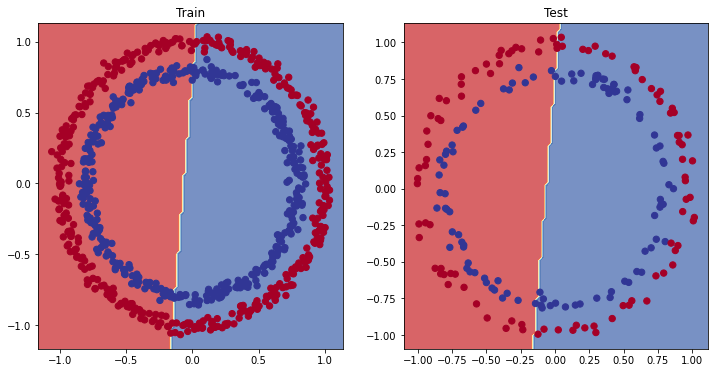

In [23]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, XTrain, yTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,XTest,yTest)

We trained a LINEAR model on NON-LINEAR data lol

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units 
* Fit for longer 
* Changing the activation function (nn.ReLU) 
* Change the learning rate
* Change the loss function 

All these are options are all from a model's perspective - can do better by cleaning data as well 

Because these options are all values that can change, referred to as **hyperparameters**

Try: 
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 200 -> 1000

In [24]:
# Create the data parameters
weight = 0.3
bias = 0.9

# Make X and y using linear regression feature
X = torch.arange(0,1,0.01).unsqueeze(dim=1)
y = weight * X + bias 

# Split the data into training and testing
trainSplit = int(0.8*len(X))

XTrain, yTrain = X[:trainSplit], y[:trainSplit]
XTest, yTest = X[trainSplit:], y[trainSplit:]

In [25]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=1,out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=1)

  def forward(self, x): 
    return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=1, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
model1.state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.7645],
                      [ 0.8300],
                      [-0.2343],
                      [ 0.9186],
                      [-0.2191],
                      [ 0.2018],
                      [-0.4869],
                      [ 0.5873],
                      [ 0.8815],
                      [-0.7336]])),
             ('layer1.bias',
              tensor([ 0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,  0.7709,  0.1478,
                      -0.4668,  0.2549])),
             ('layer2.weight',
              tensor([[-0.1457, -0.0371, -0.1284,  0.2098, -0.2496, -0.1458, -0.0893, -0.1901,
                        0.0298, -0.3123],
                      [ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -

In [27]:
# Create a loss function 
lossFn = nn.BCEWithLogitsLoss()
lossFn = nn.L1Loss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.01)

In [28]:
# Building a training and testing loop

# set manual seed 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# epoch count for printing
epochCount = 0

# set the number of epochs
epochs = 2000

# device agnostic code
XTest = XTest.to(device)
XTrain = XTrain.to(device)
yTest = yTest.to(device)
yTrain = yTrain.to(device)

for epoch in range(epochs):

  # set to training mode
  model1.train()

  # do the forward pass
  # yLogits = model1.forward(XTrain).squeeze() 
  # yPreds = torch.round(torch.sigmoid(yLogits)) # turn logits -> pred probs -> pred labels
  yPreds = model1.forward(XTrain)

  # calculate the loss
  # loss = lossFn(yLogits, yTrain) # because using BCSEWithLogitsLoss
  loss = lossFn(yPreds, yTrain)
  acc = accuracyFn(yTrue=yTrain, yPred=yPreds)
  
  # optimizer zero grad
  optimizer.zero_grad()

  # compute backward pass
  loss.backward() 

  # step through optimizer (gradient descent)
  optimizer.step()

  # increment epoch
  epochCount += 1

  if epoch % 200 == 0:

    # set model to evaluate mode
    model1.eval() 

    with torch.inference_mode():
      # testLogits = model1.forward(XTest).squeeze()
      # testPreds = torch.round(torch.sigmoid(testLogits))
      testPreds = model1.forward(XTest)
    
      # testLoss = lossFn(testLogits, yTest)
      testLoss = lossFn(testPreds, yTest)

      testAcc = accuracyFn(yTrue=yTest,yPred=testPreds)

    print(f"Epoch Number: {epochCount} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {testLoss:.5f}, Test Accurary {testAcc:.2f}%")

Epoch Number: 1 | Loss: 1.20186, Accuracy: 0.00% | Test Loss: 1.15303, Test Accurary 0.00%
Epoch Number: 201 | Loss: 0.00541, Accuracy: 0.00% | Test Loss: 0.03157, Test Accurary 0.00%
Epoch Number: 401 | Loss: 0.01828, Accuracy: 0.00% | Test Loss: 0.02650, Test Accurary 0.00%
Epoch Number: 601 | Loss: 0.00497, Accuracy: 0.00% | Test Loss: 0.03930, Test Accurary 0.00%
Epoch Number: 801 | Loss: 0.00597, Accuracy: 0.00% | Test Loss: 0.03453, Test Accurary 0.00%
Epoch Number: 1001 | Loss: 0.03056, Accuracy: 0.00% | Test Loss: 0.00298, Test Accurary 0.00%
Epoch Number: 1201 | Loss: 0.00331, Accuracy: 0.00% | Test Loss: 0.03630, Test Accurary 0.00%
Epoch Number: 1401 | Loss: 0.00230, Accuracy: 0.00% | Test Loss: 0.03499, Test Accurary 0.00%
Epoch Number: 1601 | Loss: 0.01877, Accuracy: 0.00% | Test Loss: 0.01234, Test Accurary 0.00%
Epoch Number: 1801 | Loss: 0.02815, Accuracy: 0.00% | Test Loss: 0.00075, Test Accurary 0.00%


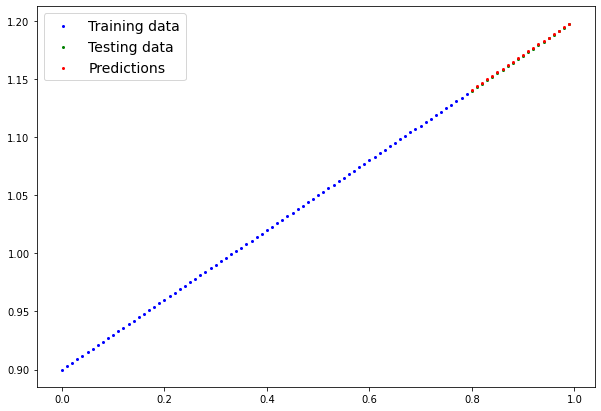

In [29]:
plot_predictions(train_data=XTrain.detach().to("cpu"), train_labels=yTrain.detach().to("cpu"), test_data=XTest.detach().to("cpu"), test_labels=yTest.detach().to("cpu"), predictions=testPreds.detach().to("cpu"))

## Scaling down

So our model works with linear data. 

## 6. The missing piece: Non-Linearity

Need to use nonlinear functions! - a large amount of linear and non-linear functions

Recreating non-linear data (red and blue circles)

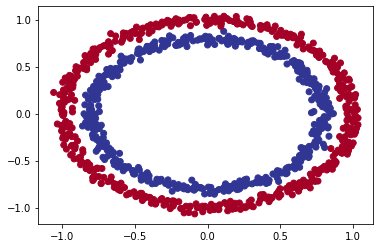

In [30]:
# Make and plot data
import matplotlib.pyplot as plot
from sklearn.datasets import make_circles

nSamples = 1000

X, y = make_circles(nSamples, 
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [31]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X,y, test_size=0.2, random_state=42)

XTrain[:5], yTrain[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [45]:
# Build a model with non-linear activation functions 
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) 

model2 = CircleModelV2().to(device)

model2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
# set up loss function 
lossFn = nn.BCEWithLogitsLoss()

# set up optimizer
optimizer = torch.optim.SGD(params=model2.parameters(),
                            lr=0.1)



In [47]:
# set up training loop 

# set random seed
torch.manual_seed(42)

# number of epochs
epochs = 2000 

# count number
epochsCount = 0

# device agnostic code
XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

for epoch in range(epochs):

  # set model to train
  model2.train()

  # 1. forward pass 
  yLogits = model2.forward(XTrain).squeeze()
  yPreds = torch.round(torch.sigmoid(yLogits))

  # 2. calculate loss 7 accuracy
  loss = lossFn(yLogits, yTrain)

  trainAcc = accuracyFn(yPred=yPreds, yTrue=yTrain)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. backpropagation 
  loss.backward()

  # 5. gradient descent
  optimizer.step()

  # increment epoch
  epochsCount += 1

  # testing
  if epoch % 100 == 0: 

    model2.eval()

    with torch.inference_mode():
      testLogits = model2.forward(XTest).squeeze()
      testPreds = torch.round(torch.sigmoid(testLogits))
    
    testLoss = lossFn(testLogits, yTest)
    testAcc = accuracyFn(yPred=testPreds, yTrue=yTest)

    print(f"Epoch Count: {epochsCount} | Train Loss: {loss:.5f}, Train Accuracy: {trainAcc:.3f}% | Train Loss: {testLoss:.5f}, Train Accuracy: {testAcc:.3f}%")

Epoch Count: 1 | Train Loss: 0.69295, Train Accuracy: 50.000% | Train Loss: 0.69319, Train Accuracy: 50.000%
Epoch Count: 101 | Train Loss: 0.69115, Train Accuracy: 52.875% | Train Loss: 0.69102, Train Accuracy: 52.500%
Epoch Count: 201 | Train Loss: 0.68977, Train Accuracy: 53.375% | Train Loss: 0.68940, Train Accuracy: 55.000%
Epoch Count: 301 | Train Loss: 0.68795, Train Accuracy: 53.000% | Train Loss: 0.68723, Train Accuracy: 56.000%
Epoch Count: 401 | Train Loss: 0.68517, Train Accuracy: 52.750% | Train Loss: 0.68411, Train Accuracy: 56.500%
Epoch Count: 501 | Train Loss: 0.68102, Train Accuracy: 52.750% | Train Loss: 0.67941, Train Accuracy: 56.500%
Epoch Count: 601 | Train Loss: 0.67515, Train Accuracy: 54.500% | Train Loss: 0.67285, Train Accuracy: 56.000%
Epoch Count: 701 | Train Loss: 0.66659, Train Accuracy: 58.375% | Train Loss: 0.66322, Train Accuracy: 59.000%
Epoch Count: 801 | Train Loss: 0.65160, Train Accuracy: 64.000% | Train Loss: 0.64757, Train Accuracy: 67.500%
Epo

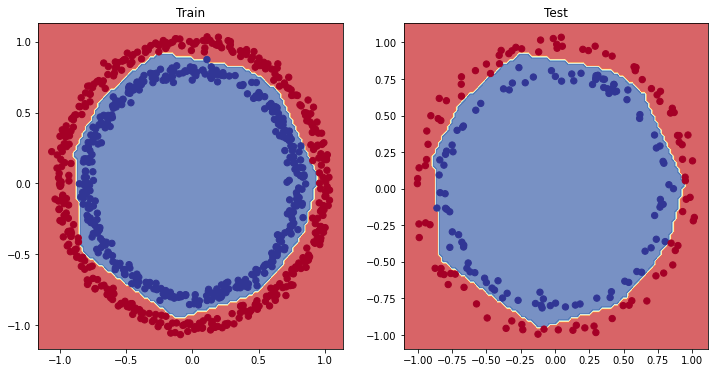

In [48]:
# Visualize the data 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model2, XTrain, yTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model2,XTest,yTest)


## 7. Replicating non-linear activation functions

Nueral networks, rather than telling the model what to learn, we give it the tools to discover patterns in data and tries to figure it out on its own

In [49]:
# Create a tensor 
A = torch.arange(-10,10,1, dtype=torch.float32)

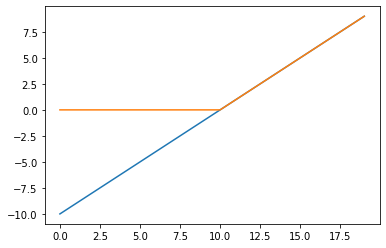

In [51]:
# visualize this tensor 
plt.plot(A);
plt.plot(torch.relu(A));

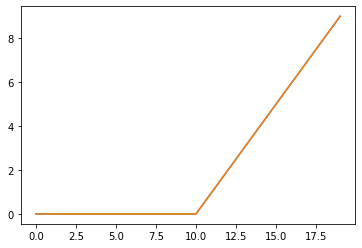

In [53]:
def relu(x):
  return torch.maximum(torch.tensor(0),x) # input must be tensors

plt.plot(relu(A));
plt.plot(torch.relu(A));

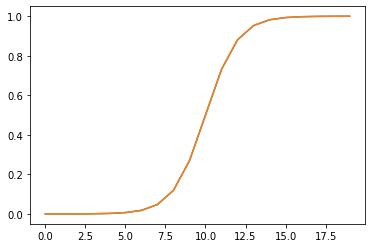

In [55]:
# Let's recreate sigmoid
def sigmoid(x):
  return 1/(1+torch.exp(-x))
plt.plot(torch.sigmoid(A));
plt.plot(sigmoid(A));

## 8. Putting it all together for a multi-class problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

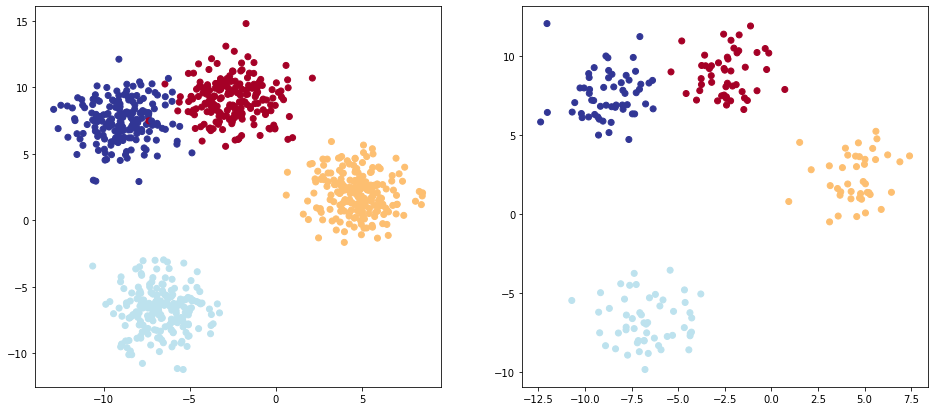

In [109]:
# 8.1 create a toy multi-class dataset

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation 
numClasses = 4
numFeatures = 2
randomSeed = 42

# 1. Create Mult-class data 
XBlob, yBlob = make_blobs(n_samples=1000, 
                          n_features=numFeatures, 
                          centers=numClasses,
                          cluster_std=1.5,
                          random_state=randomSeed)

# 2. Turn our data into tensors
XBlob = torch.from_numpy(XBlob).type(torch.float)
yBlob = torch.from_numpy(yBlob).type(torch.LongTensor)

# 3. Split into train and test
XBlobTrain, XBlobTest, yBlobTrain, yBlobTest = train_test_split(XBlob,
                                                                yBlob,
                                                                test_size=0.2,
                                                                random_state=randomSeed)

#4. Visualize the data! 
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(XBlobTrain[:,0],XBlobTrain[:,1], c=yBlobTrain,cmap=plt.cm.RdYlBu);
plt.subplot(1,2,2)
plt.scatter(XBlobTest[:,0],XBlobTest[:,1], c=yBlobTest,cmap=plt.cm.RdYlBu);

In [119]:
# 8.2 building a multi-class model 

# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model 

    Args: 
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_unit (int): Number of hidden units between layers, default 8
    
    Returns:

    Example:
    """
    super().__init__()
    
    self.linearLayerStack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  
  def forward(self, x):
    return self.linearLayerStack(x)

# create an instance of blob model
model4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)

model4

BlobModel(
  (linearLayerStack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [120]:
# 8.3 create loss and optimization 

# Create loss function 
lossFn = nn.CrossEntropyLoss()

# Create optimization
optimizer = torch.optim.SGD(params=model4.parameters(),
                            lr=0.1)



In [121]:
# 8.4 getting prediction probabilites for a multi-class PyTorch model

XBlobTrain, yBlobTrain = XBlobTrain.to(device), yBlobTrain.to(device)
XBlobTest, yBlobTest = XBlobTest.to(device), yBlobTest.to(device)

# in order to eval our model, convert our model's outputs(logits) to pred probs to pred labels
model4.eval()

with torch.inference_mode():
  # yLogits = model4(XTrain).squeeze()
  yLogits = model4(XBlobTrain)

# convert our model's logit outputs to prediction probs
yPredProbs = torch.softmax(yLogits,dim=1)

# convert probs to predictions
yPreds = torch.argmax(yPredProbs, dim=1)


In [122]:
# 8.5 Building a training + testing loop 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):

  # model to train
  model4.train()

  # 1. forward pass
  trainLogits = model4(XBlobTrain)

  # convert logits to predictions
  trainPreds = torch.softmax(trainLogits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  trainLoss = lossFn(trainLogits, yBlobTrain)

  trainAcc = accuracyFn(yTrue=yBlobTrain,
                        yPred=trainPreds)

  # 3. optimization zero grad
  optimizer.zero_grad()

  # 4. backward
  trainLoss.backward()

  # 5. step optimizer
  optimizer.step()

  if epoch % 10 == 0:

    model4.eval()

    with torch.inference_mode():
      testLogits = model4(XBlobTest)
      testPreds = torch.softmax(testLogits, dim=1).argmax(dim=1)

      testLoss = lossFn(testLogits,yBlobTest)

      testAcc = accuracyFn(yTrue=yBlobTest,
                           yPred=testPreds)
      
    print(f"Epoch Count: {epoch} | Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAcc:.2f}% | Test Loss: {testLoss:.4f}, Test Accuracy: {testAcc:.3f}% ")


Epoch Count: 0 | Train Loss: 1.1588, Train Accuracy: 40.38% | Test Loss: 1.0755, Test Accuracy: 48.000% 
Epoch Count: 10 | Train Loss: 0.6448, Train Accuracy: 96.75% | Test Loss: 0.6607, Test Accuracy: 97.500% 
Epoch Count: 20 | Train Loss: 0.4254, Train Accuracy: 98.50% | Test Loss: 0.4307, Test Accuracy: 100.000% 
Epoch Count: 30 | Train Loss: 0.2529, Train Accuracy: 99.12% | Test Loss: 0.2451, Test Accuracy: 99.500% 
Epoch Count: 40 | Train Loss: 0.1123, Train Accuracy: 99.25% | Test Loss: 0.1023, Test Accuracy: 99.500% 
Epoch Count: 50 | Train Loss: 0.0663, Train Accuracy: 99.25% | Test Loss: 0.0585, Test Accuracy: 99.500% 
Epoch Count: 60 | Train Loss: 0.0507, Train Accuracy: 99.25% | Test Loss: 0.0429, Test Accuracy: 99.500% 
Epoch Count: 70 | Train Loss: 0.0430, Train Accuracy: 99.25% | Test Loss: 0.0349, Test Accuracy: 99.500% 
Epoch Count: 80 | Train Loss: 0.0384, Train Accuracy: 99.25% | Test Loss: 0.0299, Test Accuracy: 99.500% 
Epoch Count: 90 | Train Loss: 0.0352, Train Ac

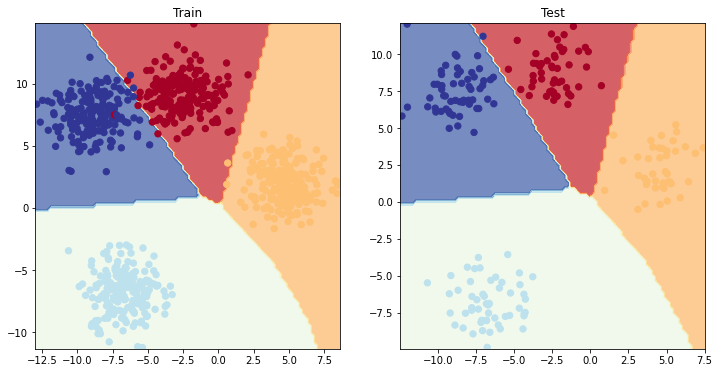

In [124]:
# Visuaaaalize! 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model4, XBlobTrain, yBlobTrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model4,XBlobTest,yBlobTest)

In [ ]:
36/60